## Deep Learning Course Project - Gesture Recognition

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

In [1]:
## Checking the GPU configuration

!nvidia-smi

Sat Sep 17 11:47:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# getting data on storage
!gdown https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
!unzip Project_data.zip

### Importing Relavant Uitlities.

In [3]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
#from cv2 import imread, resize
import datetime
import os
import abc
from sys import getsizeof
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [6]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

In [8]:
project_folder='Project_data'

##### Plotting Function

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        #lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.25, verbose=1, patience=5)
        #early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, mode='auto', verbose=1, restore_best_weights=True)
        callbacks_list = [checkpoint, lr_reducer]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = adam_v2.Adam()
        #optimiser = 'sgd'
        #optimiser = tf.keras.optimizers.RMSprop()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
#tf.keras.utils.plot_model(conv_3d1_model, to_file='sample_model.png',expand_nested=True,show_shapes=True)

##### Sample Cropping

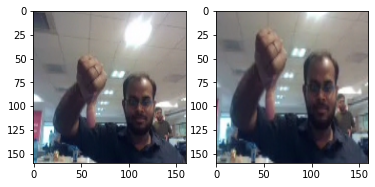

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   
plt.show()

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
conv_3d1.train_model(conv_3d1_model)

83/83 [==============================] - ETA: 0s - loss: 1.6063 - categorical_accuracy: 0.3861
Epoch 1: val_loss improved from inf to 5.16209, saving model to model_init_2022-09-1310_14_50.929319/model-00001-1.60627-0.38612-5.16209-0.16000.h5
83/83 [==============================] - 63s 740ms/step - loss: 1.6063 - categorical_accuracy: 0.3861 - val_loss: 5.1621 - val_categorical_accuracy: 0.1600 - lr: 0.0010


**We hit the limit on memory resources when image resolution is 180x180 with 30 frames and batch_size of 40...we get the below error :**

> OOM when allocating tensor with shape[40,16,30,180,180] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

**Memory was almost fully engaged for image resolution of 180x180 with 30 frames and batch_size of 32. This can be considered as limit.**

> Proceeding with 160x160 and change number of frames and batch sizes and number of epochs for futher testing.

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((32,16,30,180,180)))/(1024*1024*1024)))

Memory util is 3.7078858986496925 Gigs


#### Exploring trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size.
For all of the below experiments, it should be noted that the learning rate is kept constant.

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=4,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
166/166 [==============================] - ETA: 0s - loss: 1.8715 - categorical_accuracy: 0.2941
Epoch 1: val_loss improved from inf to 7.78777, saving model to model_init_2022-09-1310_24_49.719550/model-00001-1.87146-0.29412-7.78777-0.18000.h5
166/166 [==============================] - 60s 352ms/step - loss: 1.8715 - categorical_accuracy: 0.2941 - val_loss: 7.7878 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/3
166/166 [==============================] - ETA: 0s - loss: 1.6709 - categorical_accuracy: 0.3499
Epoch 2: val_loss improved from 7.78777 to 7.41569, saving model to model_init_2022-09-1310_24_49.719550/model-00002-1.67085-0.34992-7.41569-0.17000.h5
166/166 [==============================] - 47s 286ms/step - loss: 1.6709 - categorical_accuracy: 0.3499 - val_loss: 7.4157 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
166/166 [==============================] - ETA: 0s - loss: 1.4649 - categorical_accuracy: 0.4208
Epoch 3: val_los

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/3
83/83 [==============================] - ETA: 0s - loss: 1.5940 - categorical_accuracy: 0.3861
Epoch 1: val_loss improved from inf to 3.08683, saving model to model_init_2022-09-1310_30_34.281981/model-00001-1.59405-0.38612-3.08683-0.24000.h5
83/83 [==============================] - 47s 553ms/step - loss: 1.5940 - categorical_accuracy: 0.3861 - val_loss: 3.0868 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/3
83/83 [==============================] - ETA: 0s - loss: 1.3841 - categorical_accuracy: 0.4766
Epoch 2: val_loss did not improve from 3.08683
83/83 [==============================] - 45s 548ms/step - loss: 1.3841 - categorical_accuracy: 0.4766 - val_loss: 4.3985 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/3
83/83 [==============================] - ETA: 0s - loss: 1.2845 - categorical_accuracy: 0.4977
Epoch 3: val_loss did not improve from 3.08683
83/83 [==============================] - 46s 555ms/step - loss: 1.2845 - categorical

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
42/42 [==============================] - ETA: 0s - loss: 1.6940 - categorical_accuracy: 0.3484
Epoch 1: val_loss improved from inf to 11.09168, saving model to model_init_2022-09-1310_35_02.446438/model-00001-1.69398-0.34842-11.09168-0.16000.h5
42/42 [==============================] - 52s 1s/step - loss: 1.6940 - categorical_accuracy: 0.3484 - val_loss: 11.0917 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
42/42 [==============================] - ETA: 0s - loss: 1.2604 - categorical_accuracy: 0.5219
Epoch 2: val_loss did not improve from 11.09168
42/42 [==============================] - 52s 1s/step - loss: 1.2604 - categorical_accuracy: 0.5219 - val_loss: 16.3463 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
42/42 [==============================] - ETA: 0s - loss: 1.0347 - categorical_accuracy: 0.6018
Epoch 3: val_loss did not improve from 11.09168
42/42 [==============================] - 50s 1s/step - loss: 1.0347 - categorical_a

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
21/21 [==============================] - ETA: 0s - loss: 1.6069 - categorical_accuracy: 0.3831
Epoch 1: val_loss improved from inf to 3.12486, saving model to model_init_2022-09-1310_39_43.365300/model-00001-1.60686-0.38311-3.12486-0.16000.h5
21/21 [==============================] - 57s 3s/step - loss: 1.6069 - categorical_accuracy: 0.3831 - val_loss: 3.1249 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - ETA: 0s - loss: 1.0201 - categorical_accuracy: 0.5943
Epoch 2: val_loss did not improve from 3.12486
21/21 [==============================] - 52s 3s/step - loss: 1.0201 - categorical_accuracy: 0.5943 - val_loss: 5.5533 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/3
21/21 [==============================] - ETA: 0s - loss: 0.7631 - categorical_accuracy: 0.7195
Epoch 3: val_loss did not improve from 3.12486
21/21 [==============================] - 52s 3s/step - loss: 0.7631 - categorical_accurac

- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**, but it looks like lower batch size is working because there are more parameter updates.
- A Batch Size around 15-40 should be good.
- We will change the resoulution 160x160 to 120x120 according the model performance


## Model 1
### Base Model - Batch Size = 8 and No. of Epochs = 20

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = tf.keras.optimizers.Adam()
        optimiser = adam_v2.Adam()
        model.compile(optimizer=optimiser, loss=tf.keras.losses.CategoricalCrossentropy() , metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=20)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.7292 - categorical_accuracy: 0.3137
Epoch 1: val_loss improved from inf to 2.72117, saving model to model_init_2022-09-1311_15_14.602562/model-00001-1.72916-0.31373-2.72117-0.20000.h5
83/83 [==============================] - 63s 747ms/step - loss: 1.7292 - categorical_accuracy: 0.3137 - val_loss: 2.7212 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.3925 - categorical_accuracy: 0.4374
Epoch 2: val_loss did not improve from 2.72117
83/83 [==============================] - 52s 630ms/step - loss: 1.3925 - categorical_accuracy: 0.4374 - val_loss: 3.1695 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.2909 - categorical_accuracy: 0.4525
Epoch 3: val_loss did not improve from 2.72117
83/83 [==============================] - 52s 633ms/step - loss: 1.2909 - categor

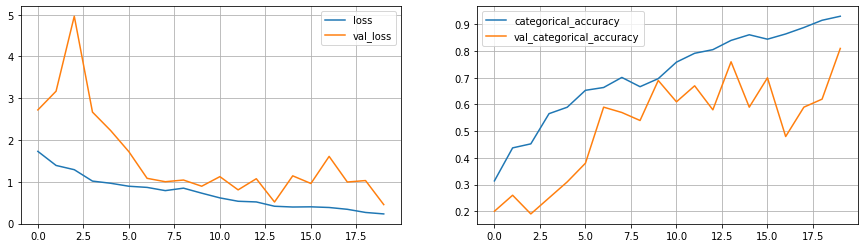

In [ ]:
plot(history_model1)

##### Model seems to be doing ok, but this can be improved.
Next, we will try to add dropout layers and see if get better results.

## Model 2  
### Adding dropout layers - Batch Size = 8 and No. of Epochs = 25

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 80, 80, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 80, 80, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 80, 80, 32)     0

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9188 - categorical_accuracy: 0.3748
Epoch 1: val_loss improved from inf to 2.24625, saving model to model_init_2022-09-1316_08_45.904762/model-00001-1.91882-0.37481-2.24625-0.23000.h5
83/83 [==============================] - 121s 1s/step - loss: 1.9188 - categorical_accuracy: 0.3748 - val_loss: 2.2463 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6229 - categorical_accuracy: 0.4427
Epoch 2: val_loss did not improve from 2.24625
83/83 [==============================] - 98s 1s/step - loss: 1.6229 - categorical_accuracy: 0.4427 - val_loss: 4.2647 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.4588 - categorical_accuracy: 0.4970
Epoch 3: val_loss did not improve from 2.24625
83/83 [==============================] - 99s 1s/step - loss: 1.4588 - categorical_acc

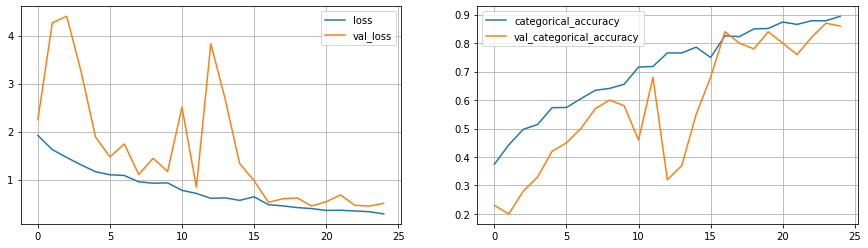

In [ ]:
plot(history_model2)

##### We were able to achieve minimum val loss of 0.45.
- The model is give a fairly regularized result, with 89% training accracy and 86% validation accuracy. Model accuracy can still be worked upon.
- Best weights save automatically. Since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002
- Also, we will try to reduce the filter size and see if get better results (improve bias). 

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 16 and No. of Epochs = 30

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 2.0453 - categorical_accuracy: 0.3650
Epoch 1: val_loss improved from inf to 2.55034, saving model to model_init_2022-09-1417_33_44.592336/model-00001-2.04531-0.36501-2.55034-0.21000.h5
42/42 [==============================] - 88s 2s/step - loss: 2.0453 - categorical_accuracy: 0.3650 - val_loss: 2.5503 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.4271 - categorical_accuracy: 0.4955
Epoch 2: val_loss did not improve from 2.55034
42/42 [==============================] - 84s 2s/step - loss: 1.4271 - categorical_accuracy: 0.4955 - val_loss: 4.3318 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.2170 - categorical_accuracy: 0.5762
Epoch 3: val_loss did not improve from 2.55034
42/42 [==============================] - 88s 2s/step - loss: 1.2170 - categori

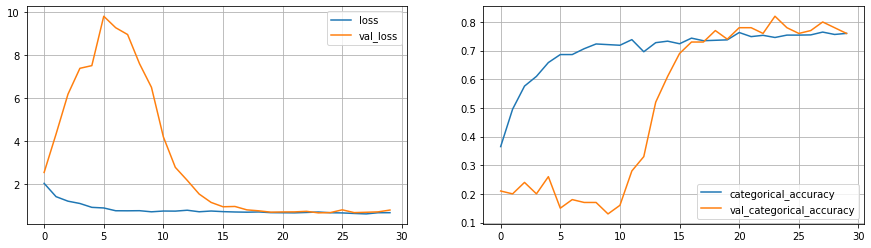

In [ ]:
plot(history_model3)

##### Model performed relatively poorly in terms of accuracy with validation accuracy of 76% and training accuracy of 76%. It's clear that the present model is well regularized.
From the above plots it clear that for a higher resolution of image and more batch size the model has difficulty learning in the initial stages but makes up for it later.

Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers.

## Model 4 - 
### Adding more layers - Batch Size = 16 and No. of Epochs = 30

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam()
        optimiser = adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_19 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.9713 - categorical_accuracy: 0.3665
Epoch 1: val_loss improved from inf to 2.32592, saving model to model_init_2022-09-1418_37_08.435554/model-00001-1.97127-0.36652-2.32592-0.23000.h5
42/42 [==============================] - 101s 2s/step - loss: 1.9713 - categorical_accuracy: 0.3665 - val_loss: 2.3259 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.6864 - categorical_accuracy: 0.4246
Epoch 2: val_loss did not improve from 2.32592
42/42 [==============================] - 97s 2s/step - loss: 1.6864 - categorical_accuracy: 0.4246 - val_loss: 2.6034 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.4011 - categorical_accuracy: 0.4879
Epoch 3: val_loss did not improve from 2.32592
42/42 [==============================] - 97s 2s/step - loss: 1.4011 - categorical_acc

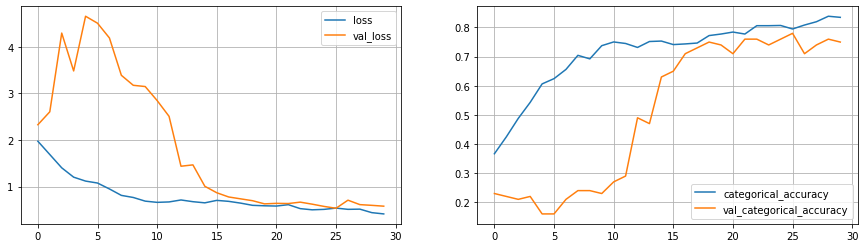

In [ ]:
plot(history_model4)

##### With more layers there is a slight improvement in performance. We get a best validation accuracy of 75% . 
The model is still reasonably well regularized.
Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam()
        optimiser = adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.7602 - categorical_accuracy: 0.3839
Epoch 1: val_loss improved from inf to 3.04115, saving model to model_init_2022-09-1509_07_26.917237/model-00001-1.76018-0.38386-3.04115-0.16000.h5
42/42 [==============================] - 111s 2s/step - loss: 1.7602 - categorical_accuracy: 0.3839 - val_loss: 3.0412 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3378 - categorical_accuracy: 0.4736
Epoch 2: val_loss did not improve from 3.04115
42/42 [==============================] - 90s 2s/step - loss: 1.3378 - categorical_accuracy: 0.4736 - val_loss: 10.1830 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.2009 - categorical_accuracy: 0.5437
Epoch 3: val_loss did not improve from 3.04115
42/42 [==============================] - 91s 2s/step - loss: 1.2009 - categorical_ac

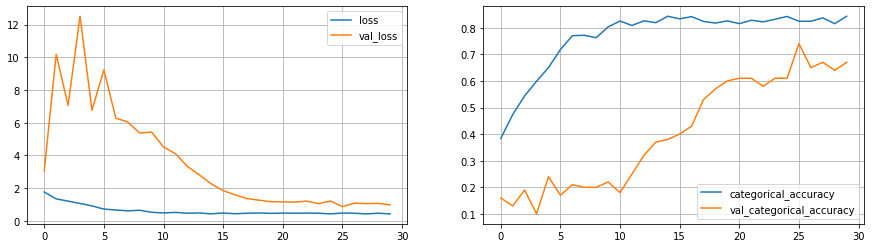

In [ ]:
plot(history_model5)

 __Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 50, 50, 32)     0

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.9534 - categorical_accuracy: 0.2956
Epoch 1: val_loss improved from inf to 1.99033, saving model to model_init_2022-09-1510_28_57.522594/model-00001-1.95336-0.29563-1.99033-0.16000.h5
42/42 [==============================] - 100s 2s/step - loss: 1.9534 - categorical_accuracy: 0.2956 - val_loss: 1.9903 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.2761 - categorical_accuracy: 0.5173
Epoch 2: val_loss did not improve from 1.99033
42/42 [==============================] - 86s 2s/step - loss: 1.2761 - categorical_accuracy: 0.5173 - val_loss: 3.1859 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.0485 - categorical_accuracy: 0.5943
Epoch 3: val_loss did not improve from 1.99033
42/42 [==============================] - 85s 2s/step - loss: 1.0485 - categori

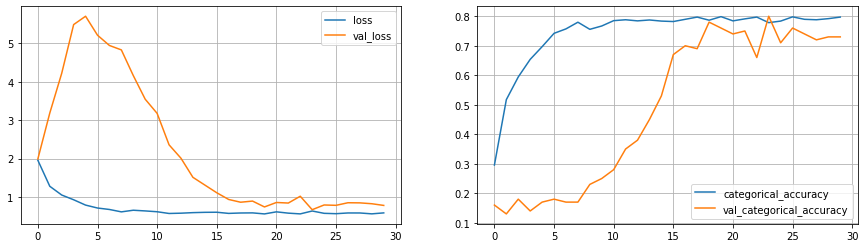

In [ ]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 76%

## Model 7 - Reducing the number of parameters again

In [ ]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.8455 - categorical_accuracy: 0.3522
Epoch 1: val_loss improved from inf to 2.05244, saving model to model_init_2022-09-1511_21_56.301212/model-00001-1.84554-0.35219-2.05244-0.16000.h5
42/42 [==============================] - 92s 2s/step - loss: 1.8455 - categorical_accuracy: 0.3522 - val_loss: 2.0524 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.2825 - categorical_accuracy: 0.5181
Epoch 2: val_loss did not improve from 2.05244
42/42 [==============================] - 88s 2s/step - loss: 1.2825 - categorical_accuracy: 0.5181 - val_loss: 2.9810 - val_categorical_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.0994 - categorical_accuracy: 0.5618
Epoch 3: val_loss did not improve from 2.05244
42/42 [==============================] - 90s 2s/step - loss: 1.0994 - categoric

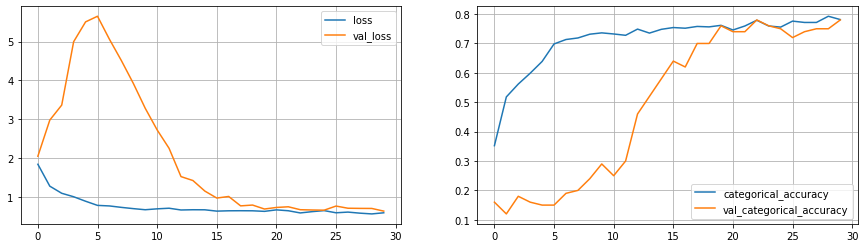

In [ ]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 78%. The model give a decent accuravy and is reasonably well regularised.

## Model 8(a) - CNN- LSTM Model

In [ ]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        #optimiser = optimizers.Adam()
        optimiser = adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=24,num_epochs=30)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 1.4764 - categorical_accuracy: 0.3688
Epoch 1: val_loss improved from inf to 1.64507, saving model to model_init_2022-09-1512_14_24.794297/model-00001-1.47639-0.36878-1.64507-0.21000.h5
28/28 [==============================] - 116s 4s/step - loss: 1.4764 - categorical_accuracy: 0.3688 - val_loss: 1.6451 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 1.2478 - categorical_accuracy: 0.4532
Epoch 2: val_loss did not improve from 1.64507
28/28 [==============================] - 101s 4s/step - loss: 1.2478 - categorical_accuracy: 0.4532 - val_loss: 1.7857 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 1.0533 - categorical_accuracy: 0.5754
Epoch 3: val_loss did not improve from 1.64507
28/28 [==============================] - 102s 4s/step - loss: 1.0533 - categorical_a

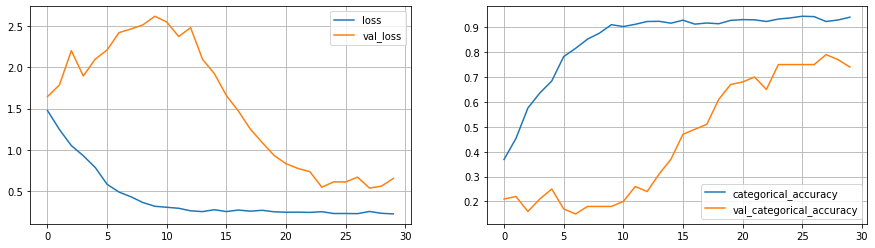

In [ ]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 79%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Model 8(b) - CNN- LSTM Model

In [ ]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        #optimiser = optimizers.Adam()
        optimiser = adam_v2.Adam(lr=0.0005)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=16,batch_size=18,num_epochs=50)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 16, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 1.4411 - categorical_accuracy: 0.3861
Epoch 1: val_loss improved from inf to 1.75084, saving model to model_init_2022-09-1618_48_53.675201/model-00001-1.44109-0.38612-1.75084-0.16000.h5
37/37 [==============================] - 103s 3s/step - loss: 1.4411 - categorical_accuracy: 0.3861 - val_loss: 1.7508 - val_categorical_accuracy: 0.1600 - lr: 5.0000e-04
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 1.1904 - categorical_accuracy: 0.5204
Epoch 2: val_loss improved from 1.75084 to 1.71298, saving model to model_init_2022-09-1618_48_53.675201/model-00002-1.19035-0.52036-1.71298-0.17000.h5
37/37 [==============================] - 92s 3s/step - loss: 1.1904 - categorical_accuracy: 0.5204 - val_loss: 1.7130 - val_categorical_accuracy: 0.1700 - lr: 5.0000e-04
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 1.0440 - categorical_accuracy: 0.5701
Epoch 3: val_loss i

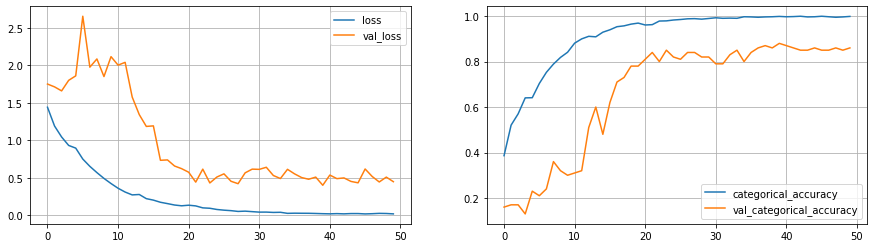

In [ ]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 88%

Overfitting still persists, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        #LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.25, verbose=1, patience=5)
        #early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, mode='auto', verbose=1, restore_best_weights=True)
        callbacks_list = [checkpoint, lr_reducer]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

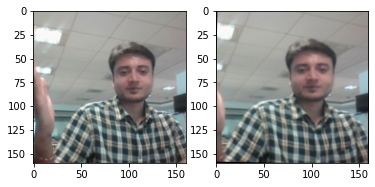

In [ ]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:]) 
plt.show()

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [ ]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 80, 80, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 80, 80, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 80, 80, 32)     0

In [ ]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 2.0565 - categorical_accuracy: 0.3371
Epoch 1: saving model to model_init_2022-09-1513_17_23.077430/model-00001-2.05652-0.33710-2.02974-0.16000.h5
83/83 [==============================] - 107s 1s/step - loss: 2.0565 - categorical_accuracy: 0.3371 - val_loss: 2.0297 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.6673 - categorical_accuracy: 0.4615
Epoch 2: saving model to model_init_2022-09-1513_17_23.077430/model-00002-1.66734-0.46154-3.35410-0.18000.h5
83/83 [==============================] - 102s 1s/step - loss: 1.6673 - categorical_accuracy: 0.4615 - val_loss: 3.3541 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.3691 - categorical_accuracy: 0.5249
Epoch 3: saving model to model_init_2022-09-1513_17_23.077430/model-00003-1.36907-0.52489-4.71271-0.

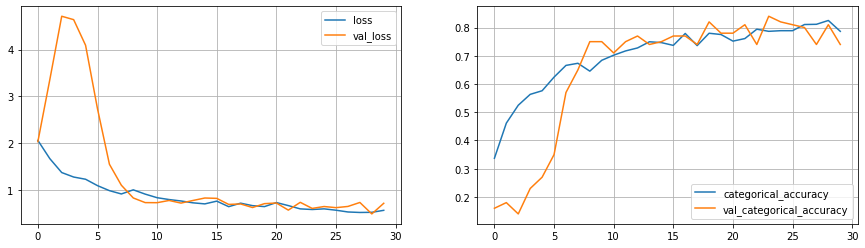

In [ ]:
plot(history_model9)

82% training accuracy and 81% val accuracy.

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 2.0367 - categorical_accuracy: 0.3560
Epoch 1: saving model to model_init_2022-09-1514_16_41.549267/model-00001-2.03669-0.35596-3.27631-0.16000.h5
42/42 [==============================] - 93s 2s/step - loss: 2.0367 - categorical_accuracy: 0.3560 - val_loss: 3.2763 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.5493 - categorical_accuracy: 0.4857
Epoch 2: saving model to model_init_2022-09-1514_16_41.549267/model-00002-1.54929-0.48567-6.21756-0.13000.h5
42/42 [==============================] - 90s 2s/step - loss: 1.5493 - categorical_accuracy: 0.4857 - val_loss: 6.2176 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.2573 - categorical_accuracy: 0.5370
Epoch 3: saving model to model_init_2022-09-1514_16_41.549267/model-00003-1.25727-0.53695-9.42070-0.15

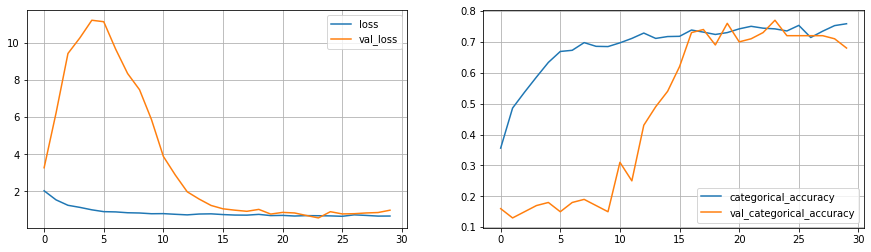

In [ ]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_13 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 2.1197 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2022-09-1515_11_30.291626/model-00001-2.11971-0.33333-1.99776-0.21000.h5
42/42 [==============================] - 99s 2s/step - loss: 2.1197 - categorical_accuracy: 0.3333 - val_loss: 1.9978 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.6455 - categorical_accuracy: 0.4397
Epoch 2: saving model to model_init_2022-09-1515_11_30.291626/model-00002-1.64546-0.43967-3.08604-0.13000.h5
42/42 [==============================] - 95s 2s/step - loss: 1.6455 - categorical_accuracy: 0.4397 - val_loss: 3.0860 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.4529 - categorical_accuracy: 0.5249
Epoch 3: saving model to model_init_2022-09-1515_11_30.291626/model-00003-1.45286-0.52489-3.91729-0.16

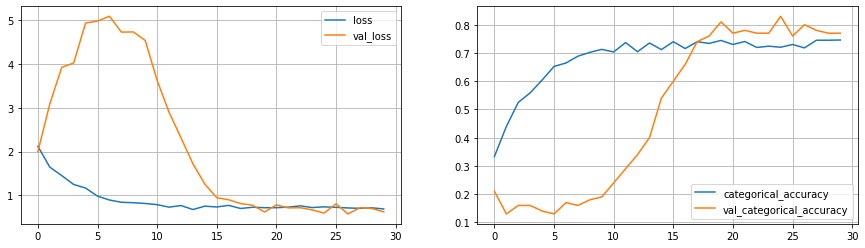

In [ ]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.9697 - categorical_accuracy: 0.2949
Epoch 1: saving model to model_init_2022-09-1517_48_55.313286/model-00001-1.96971-0.29487-1.99106-0.21000.h5
42/42 [==============================] - 105s 2s/step - loss: 1.9697 - categorical_accuracy: 0.2949 - val_loss: 1.9911 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.6462 - categorical_accuracy: 0.3861
Epoch 2: saving model to model_init_2022-09-1517_48_55.313286/model-00002-1.64619-0.38612-2.87609-0.17000.h5
42/42 [==============================] - 88s 2s/step - loss: 1.6462 - categorical_accuracy: 0.3861 - val_loss: 2.8761 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.5289 - categorical_accuracy: 0.4140
Epoch 3: saving model to model_init_2022-09-1517_48_55.313286/model-00003-1.52890-0.41403-4.34365-0.1

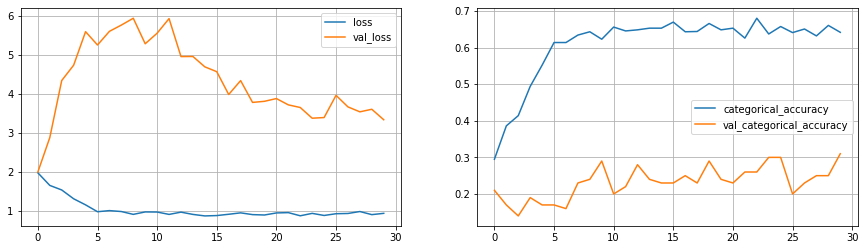

In [ ]:
plot(history_model12)

Model is overfitting badly !!

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 50, 50, 32)    

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.7482 - categorical_accuracy: 0.3431
Epoch 1: saving model to model_init_2022-09-1518_40_04.414114/model-00001-1.74821-0.34314-2.14462-0.21000.h5
42/42 [==============================] - 82s 2s/step - loss: 1.7482 - categorical_accuracy: 0.3431 - val_loss: 2.1446 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.2468 - categorical_accuracy: 0.5121
Epoch 2: saving model to model_init_2022-09-1518_40_04.414114/model-00002-1.24680-0.51207-3.34527-0.20000.h5
42/42 [==============================] - 78s 2s/step - loss: 1.2468 - categorical_accuracy: 0.5121 - val_loss: 3.3453 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.0570 - categorical_accuracy: 0.6078
Epoch 3: saving model to model_init_2022-09-1518_40_04.414114/model-00003-1.05704-0.60784-3.65764-0.260

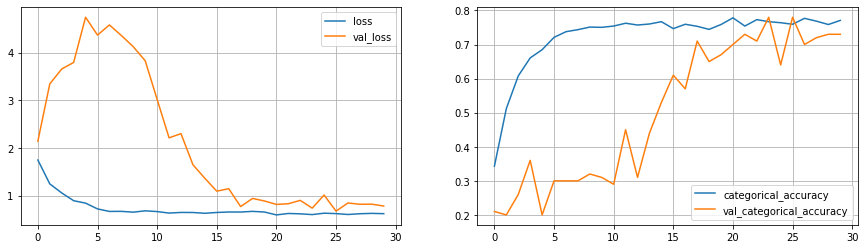

In [ ]:
plot(history_model13)

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_14 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.8494 - categorical_accuracy: 0.3145
Epoch 1: saving model to model_init_2022-09-1608_21_57.036885/model-00001-1.84936-0.31448-2.16128-0.16000.h5
42/42 [==============================] - 112s 2s/step - loss: 1.8494 - categorical_accuracy: 0.3145 - val_loss: 2.1613 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3531 - categorical_accuracy: 0.4630
Epoch 2: saving model to model_init_2022-09-1608_21_57.036885/model-00002-1.35307-0.46305-4.52262-0.16000.h5
42/42 [==============================] - 98s 2s/step - loss: 1.3531 - categorical_accuracy: 0.4630 - val_loss: 4.5226 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.1803 - categorical_accuracy: 0.5385
Epoch 3: saving model to model_init_2022-09-1608_21_57.036885/model-00003-1.18026-0.53846-6.06179-0.12

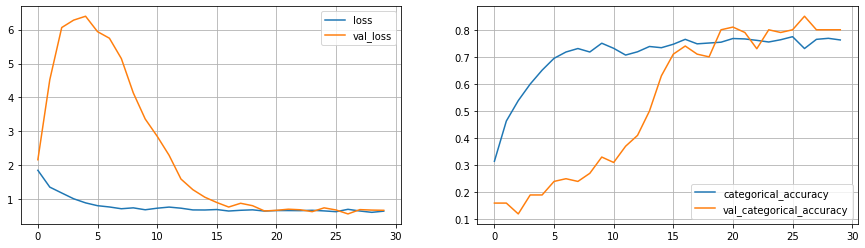

In [ ]:
plot(history_model14)

## Model 15(a) with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
#training the mode for 50 epochs this time around
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=24,num_epochs=50)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 1.5160 - categorical_accuracy: 0.3507
Epoch 1: saving model to model_init_2022-09-1610_19_12.857130/model-00001-1.51598-0.35068-1.70790-0.29000.h5
28/28 [==============================] - 110s 4s/step - loss: 1.5160 - categorical_accuracy: 0.3507 - val_loss: 1.7079 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 1.0612 - categorical_accuracy: 0.5611
Epoch 2: saving model to model_init_2022-09-1610_19_12.857130/model-00002-1.06122-0.56109-2.29790-0.29000.h5
28/28 [==============================] - 105s 4s/step - loss: 1.0612 - categorical_accuracy: 0.5611 - val_loss: 2.2979 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.8053 - categorical_accuracy: 0.6946
Epoch 3: saving model to model_init_2022-09-1610_19_12.857130/model-00003-0.80527-0.69457-2.64223-0.

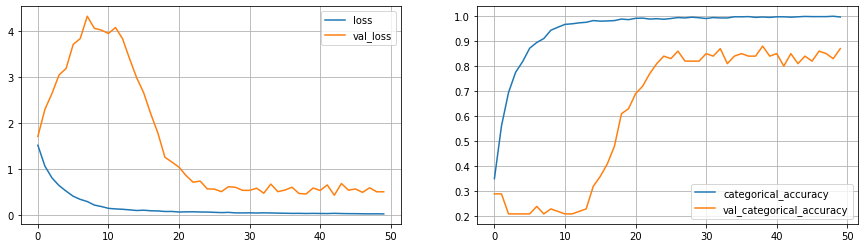

In [ ]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 15(b) with Augmentation
### CNN LSTM with GRU - Similar to Model 8
With slight modification on 15(a), batch size reduced to 16. One more FC layer added before output layer. Initial LR = 0.0005.

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))      

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(2*dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        #optimiser = optimizers.Adam(lr=0.0002)
        optimiser = adam_v2.Adam(lr=0.0005)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
#training the mode for 50 epochs this time around
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=16,num_epochs=30)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 1395813
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.5360 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2022-09-1706_37_11.451010/model-00001-1.53604-0.33333-2.04146-0.21000.h5
42/42 [==============================] - 116s 2s/step - loss: 1.5360 - categorical_accuracy: 0.3333 - val_loss: 2.0415 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.1820 - categorical_accuracy: 0.5023
Epoch 2: saving model to model_init_2022-09-1706_37_11.451010/model-00002-1.18201-0.50226-3.30139-0.18000.h5
42/42 [==============================] - 101s 2s/step - loss: 1.1820 - categorical_accuracy: 0.5023 - val_loss: 3.3014 - val_categorical_accuracy: 0.1800 - lr: 5.0000e-04
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.9750 - categorical_accuracy: 0.6063
Epoch 3: saving model to model_init_2022-09-1706_37_11.451010/model-00003-0.97496-0.60633-3.32741-0.

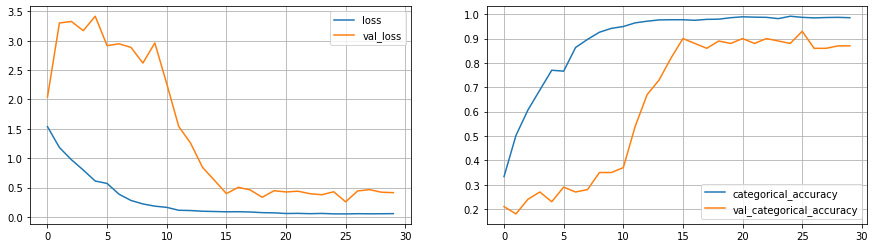

In [ ]:
plot(history_model15)

### There is still some degree of overfitting, but this model has given the best validation accuracy by far at 26th epoch.
Best Val Accuracy: 93%
Corresponding Training accuracy: 98%. 

## Model 16 - Let us bring in Transfer Learning !! (MobileNet)

In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        #optimiser = optimizers.Adam()
        optimiser = adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.3666 - categorical_accuracy: 0.4193
Epoch 1: saving model to model_init_2022-09-1613_07_34.854162/model-00001-1.36657-0.41931-1.09770-0.58000.h5
42/42 [==============================] - 96s 2s/step - loss: 1.3666 - categorical_accuracy: 0.4193 - val_loss: 1.0977 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.8186 - categorical_accuracy: 0.6900
Epoch 2: saving model to model_init_2022-09-1613_07_34.854162/model-00002-0.81857-0.69005-0.85820-0.67000.h5
42/42 [==============================] - 87s 2s/step - loss: 0.8186 - categorical_accuracy: 0.6900 - val_loss: 0.8582 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.5284 - categorical_accuracy: 0.8107
Epoch 3: saving model to model_init_2022-09-1613_07_34.854162/model-00003-0.52842-0.81071-0.62661-0.77000.h5
4

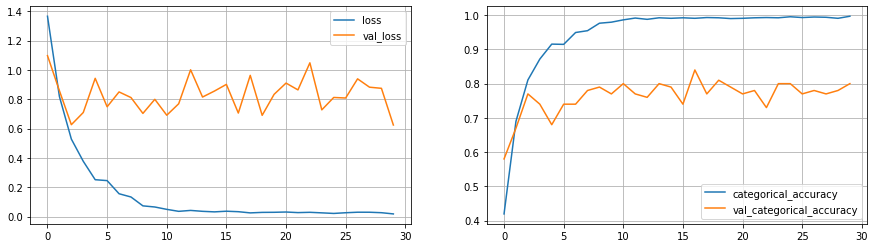

In [ ]:
plot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        #optimiser = optimizers.Adam()
        optimiser = adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=16,num_epochs=30)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.1389 - categorical_accuracy: 0.5513
Epoch 1: saving model to model_init_2022-09-1613_53_30.851256/model-00001-1.13891-0.55128-0.90411-0.59000.h5
42/42 [==============================] - 105s 2s/step - loss: 1.1389 - categorical_accuracy: 0.5513 - val_loss: 0.9041 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.3908 - categorical_accuracy: 0.8514
Epoch 2: saving model to model_init_2022-09-1613_53_30.851256/model-00002-0.39075-0.85143-0.48342-0.78000.h5
42/42 [==============================] - 91s 2s/step - loss: 0.3908 - categorical_accuracy: 0.8514 - val_loss: 0.4834 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.1670 - categorical_accuracy: 0.9502
Epoch 3: saving model to model_init_2022-09-1613_53_30.851256/model-00003-0.16702-0.95023-0.52547-0.82000.h5


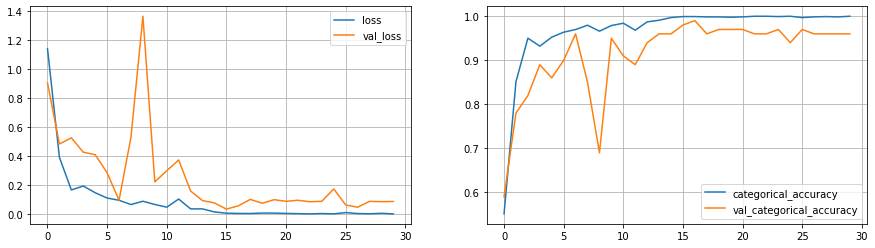

In [ ]:
plot(history_model17)

### This phenomenal result! Best Val accuracy achieved was 99.00% with corresponding training accuracy of 99.92%.

# Consolidated Final Models

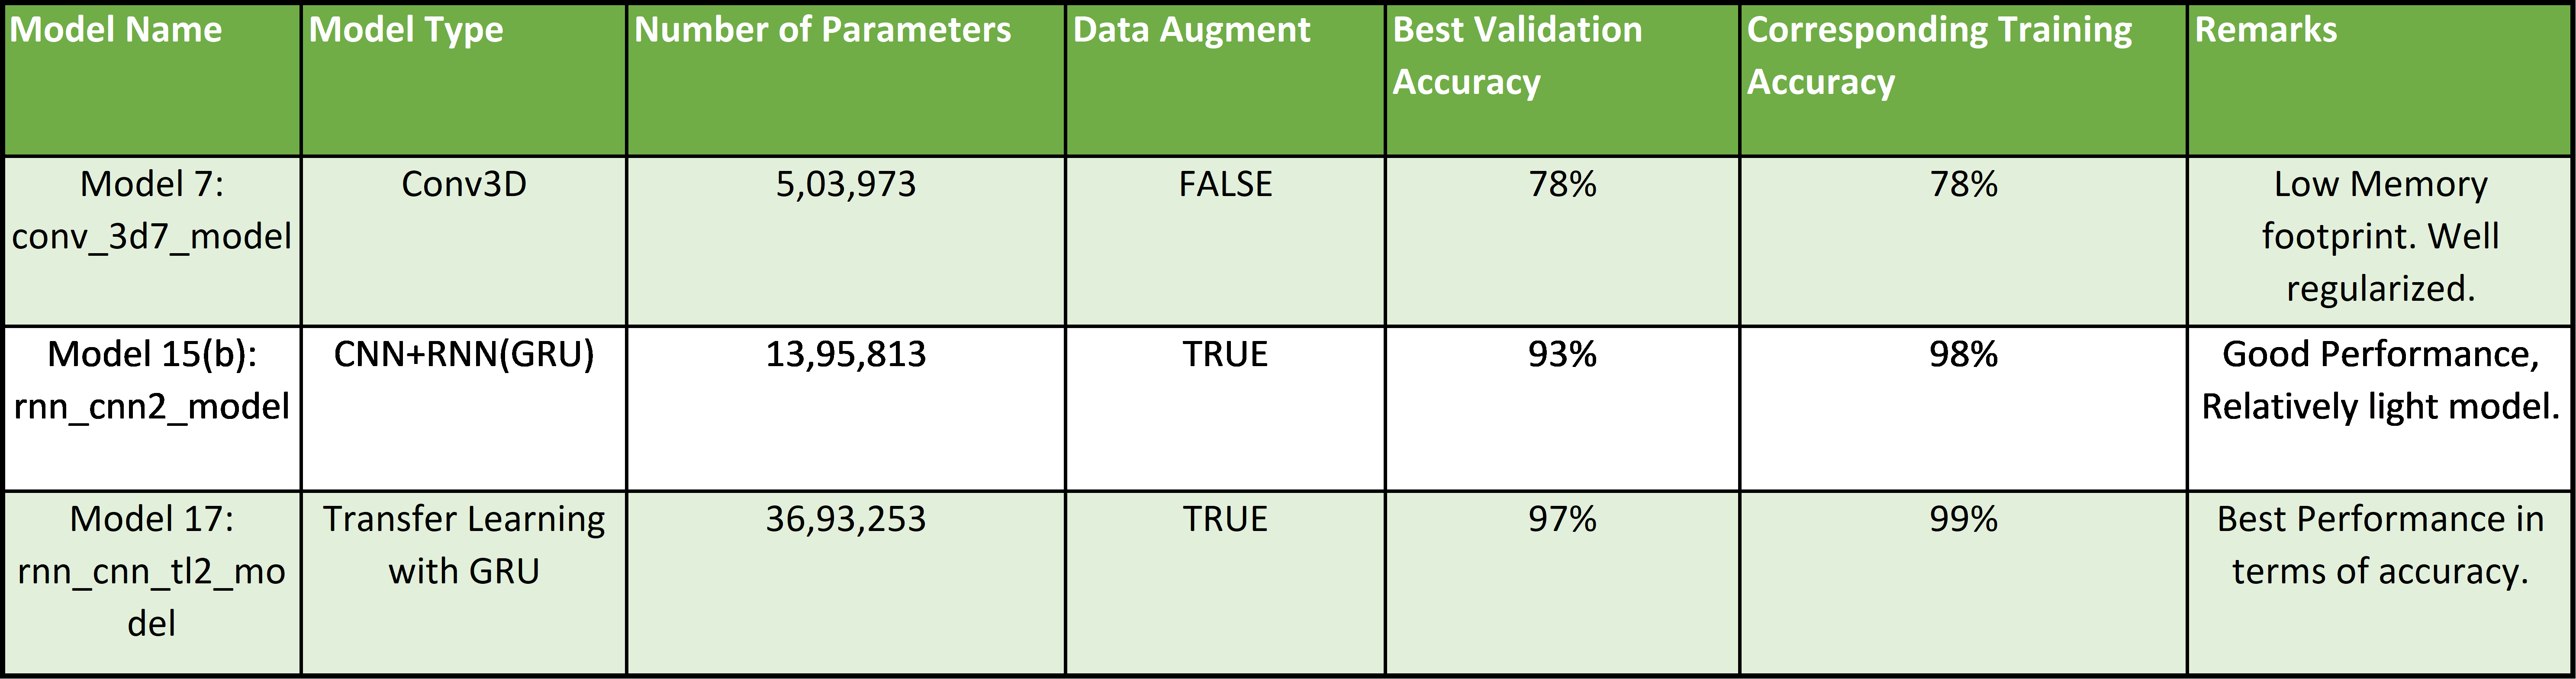

## After doing all the experiments, we finalized Model 15(b) - CNN+GRU with augmentation as the final model.

- Training Accuracy : 98%, Validation Accuracy : 93%. Very good validation accuracy.

- Number of Parameters, Total params: 1,395,813 with Trainable params: 1,394,821, which is decent when compared to other models. Model is not too heavy and gives good results.

- Learning rate decay was crucial in achieving this accuracy. 


The best weights of CNN-LSTM(GRU): **model-00026-0.05170-0.98718-0.25728-0.93000.h5 (16.11 MB)**. we considered this weight for model testing, Let's have look at the performance below.


# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('model-00026-0.05170-0.98718-0.25728-0.93000.h5')   #renamed as final_model(CNN_GRU).h5

In [ ]:
test_generator=RNNCNN2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=16,num_epochs=30)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4 0 2 4 0 4 1 1 2 0 1 2 0 0 3 2]
